In [1]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten, Activation, Input
from tensorflow.python.keras.layers import Dropout, Conv2D, MaxPooling2D
from tensorflow.python.keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
clock_path = os.path.join("data", "clock")
crocodile_path = os.path.join("data", "crocodile")

validation_size = 0.1
test_size = 0.15

batch_size = 16

img_width = 32
img_height = 32

## Подготовим данные

In [3]:
def get_files_list(dir_path):
    return [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

In [4]:
def load_images(image_path):
    images = []
    image_list = get_files_list(image_path)
    for i in image_list:
        img = image.load_img(os.path.join(image_path, i), target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x /= 255
        images.append(x)
    return images

In [5]:
clock_images_list = load_images(clock_path)
crocodile_images_list = load_images(crocodile_path)

X = np.array(clock_images_list + crocodile_images_list)
y = np.array([0]*len(clock_images_list) + [1]*len(crocodile_images_list))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

## Построим и протестируем классификатор

In [7]:
input_img = Input(shape=(img_width, img_height, 3))

model = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
model = Conv2D(32, (3, 3), padding='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.25)(model)

model = Conv2D(128, (3, 3), padding='same', activation='relu')(model)
model = Conv2D(128, (3, 3), padding='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Dropout(0.25)(model)

model = Flatten()(model)
model = Dense(1024, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)

classifier = Model(input_img, model, name="classifier")

In [8]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [9]:
history = classifier.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

Train on 765 samples, validate on 85 samples
Epoch 1/30
765/765 [==============================] - 6s - loss: 0.6847 - acc: 0.5072 - val_loss: 0.6768 - val_acc: 0.6353
Epoch 2/30
765/765 [==============================] - 2s - loss: 0.6188 - acc: 0.6458 - val_loss: 0.5363 - val_acc: 0.7176
Epoch 3/30
765/765 [==============================] - 2s - loss: 0.5325 - acc: 0.7425 - val_loss: 0.4865 - val_acc: 0.7412
Epoch 4/30
765/765 [==============================] - 2s - loss: 0.4611 - acc: 0.7869 - val_loss: 0.4629 - val_acc: 0.7529
Epoch 5/30
765/765 [==============================] - 2s - loss: 0.4485 - acc: 0.8039 - val_loss: 0.4029 - val_acc: 0.8118
Epoch 6/30
765/765 [==============================] - 2s - loss: 0.4386 - acc: 0.8039 - val_loss: 0.3231 - val_acc: 0.8824
Epoch 7/30
765/765 [==============================] - 3s - loss: 0.3940 - acc: 0.8196 - val_loss: 0.3313 - val_acc: 0.8471
Epoch 8/30
765/765 [==============================] - 6s - loss: 0.3799 - acc: 0.8379 - val_lo

## Результаты

In [10]:
print("accuracy: {:.2f}%".format(classifier.evaluate(X_test, y_test, batch_size=batch_size)[1] * 100))

150/150 [==============================] - 0s     
accuracy: 92.00%


Text(0.5,1,'validation accuracy')

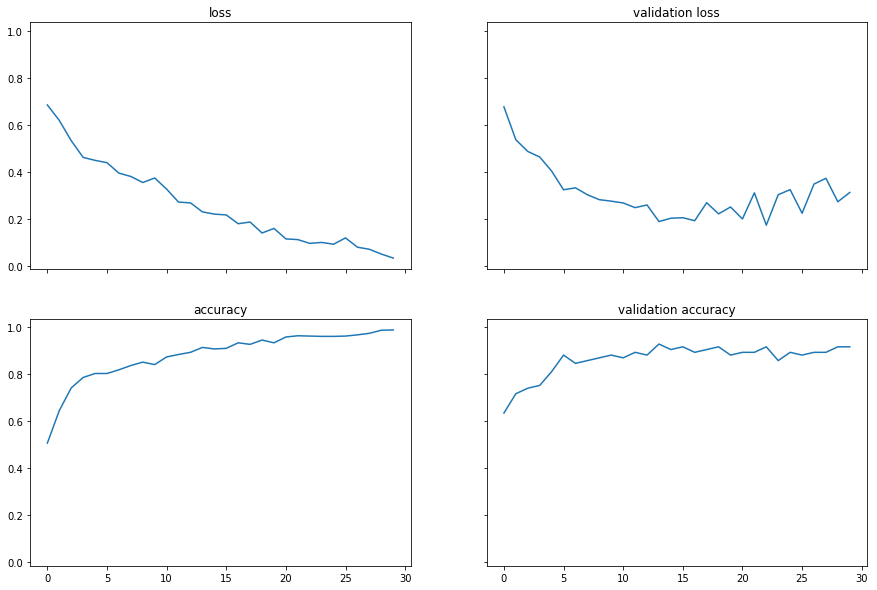

In [11]:
fig, axis = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(15, 10))

axis[0, 0].plot(history.history['loss'])
axis[0, 0].set_title('loss')

axis[0, 1].plot(history.history['val_loss'])
axis[0, 1].set_title('validation loss')

axis[1, 0].plot(history.history['acc'])
axis[1, 0].set_title('accuracy')

axis[1, 1].plot(history.history['val_acc'])
axis[1, 1].set_title('validation accuracy')

In [12]:
with open("classifier.json", "w") as f:
    f.write(classifier.to_json())
classifier.save_weights("classifier.h5")